In [4]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import ast
import pandas as pd
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sqlalchemy import create_engine
import json
warnings.filterwarnings("ignore")

In [2]:
START_DATE = datetime(2021, 1, 26)
today = datetime.today()
day_list = []

while START_DATE <= today:
    day_list.append(START_DATE)
    START_DATE += timedelta(days=1)

day_list

[datetime.datetime(2021, 1, 26, 0, 0),
 datetime.datetime(2021, 1, 27, 0, 0),
 datetime.datetime(2021, 1, 28, 0, 0),
 datetime.datetime(2021, 1, 29, 0, 0),
 datetime.datetime(2021, 1, 30, 0, 0),
 datetime.datetime(2021, 1, 31, 0, 0),
 datetime.datetime(2021, 2, 1, 0, 0),
 datetime.datetime(2021, 2, 2, 0, 0),
 datetime.datetime(2021, 2, 3, 0, 0),
 datetime.datetime(2021, 2, 4, 0, 0),
 datetime.datetime(2021, 2, 5, 0, 0),
 datetime.datetime(2021, 2, 6, 0, 0),
 datetime.datetime(2021, 2, 7, 0, 0),
 datetime.datetime(2021, 2, 8, 0, 0),
 datetime.datetime(2021, 2, 9, 0, 0),
 datetime.datetime(2021, 2, 10, 0, 0),
 datetime.datetime(2021, 2, 11, 0, 0),
 datetime.datetime(2021, 2, 12, 0, 0),
 datetime.datetime(2021, 2, 13, 0, 0),
 datetime.datetime(2021, 2, 14, 0, 0),
 datetime.datetime(2021, 2, 15, 0, 0),
 datetime.datetime(2021, 2, 16, 0, 0),
 datetime.datetime(2021, 2, 17, 0, 0),
 datetime.datetime(2021, 2, 18, 0, 0),
 datetime.datetime(2021, 2, 19, 0, 0),
 datetime.datetime(2021, 2, 20, 0,

In [7]:
df = pd.DataFrame()
for date in day_list:
    day = date.day
    month = date.month
    year = date.year

    print(f'Current processed day: {day}.{month}.{year}')
    

    url = f"http://www.wiatrkadyny.pl/rewa/wxwugraphs/graphd1a.php?theme=pepper&d={day}&m={month}&y={year}&w=900&h=350"


    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
    else:
        print(f"Failed to fetch data from {url}")

    patternWindSpeed = r'var dAvgWS\s*=\s*(\[.*?\]);'
    patternWindGust = r'var dGustWS\s*=\s*(\[.*?\]);'
    patternTemp = r'var dTemp\s*=\s*(\[.*?\]);'
    patternWindDir = r'var dWindDir\s*=\s*(\[.*?\]);'
    patternBaro = r'var dBaro\s*=\s*(\[.*?\]);'

    # Use re.findall to find all matches in the HTML content
    WindSpeed = re.findall(patternWindSpeed, str(soup.contents), re.IGNORECASE | re.DOTALL)
    WindGust = re.findall(patternWindGust, str(soup.contents), re.IGNORECASE | re.DOTALL)
    Temp = re.findall(patternTemp, str(soup.contents), re.IGNORECASE | re.DOTALL)
    WindDir = re.findall(patternWindDir, str(soup.contents), re.IGNORECASE | re.DOTALL)
    Baro = re.findall(patternBaro, str(soup.contents), re.IGNORECASE | re.DOTALL)

    # Remove the trailing comma to make it a valid JSON-like format
    WindSpeed = ast.literal_eval(WindSpeed[0].rstrip(','))[:-1]
    WindGust = ast.literal_eval(WindGust[0].rstrip(','))[:-1]
    Temp = ast.literal_eval(Temp[0].rstrip(','))[:-1]
    WindDir = ast.literal_eval(WindDir[0].rstrip(','))[:-1]
    Baro = ast.literal_eval(Baro[0].rstrip(','))[:-1]

    # Convert from m/s to knots
    WindSpeed = [np.round(speed * 1.94384449,2) for speed in WindSpeed]
    WindGust = [np.round(speed * 1.94384449,2) for speed in WindGust]

    # Define the date and time components
    hour = 0  # Starting hour
    minute = 0  # Starting minute
    second = 0  # Starting second

    # Create a list to store datetime values
    datetime_values = []

    # Define the time interval (10 minutes)
    time_interval = timedelta(minutes=10)

    # Create datetime values with 10-minute intervals for the entire day
    while hour < 24:
        current_datetime = datetime(year, month, day, hour, minute, second)
        datetime_values.append(current_datetime)
        minute += 10
        if minute == 60:
            minute = 0
            hour += 1

    print(len(WindSpeed))
    print(len(datetime_values[:(len(WindSpeed))]))

    # Create a DataFrame
    data = {
        'Time': datetime_values[:(len(WindSpeed))],
        'WindSpeed': WindSpeed,
        'WindGust': WindGust,
        'Temp': Temp,
        'WindDir': WindDir,
        'Baro': Baro
    }
    try:
        df_i = pd.DataFrame(data)
        df = pd.concat([df,df_i])
    except:
        print(f'Data inconsistent for day: {day}.{month}.{year}. Skiping...')
        pass
    time.sleep(3)


Current processed day: 26.1.2021
144
144
Current processed day: 27.1.2021
144
144
Current processed day: 28.1.2021
144
144
Current processed day: 29.1.2021
144
144
Current processed day: 30.1.2021
144
144
Current processed day: 31.1.2021
144
144
Current processed day: 1.2.2021
144
144
Current processed day: 2.2.2021
144
144
Current processed day: 3.2.2021
144
144
Current processed day: 4.2.2021
144
144
Current processed day: 5.2.2021
144
144
Current processed day: 6.2.2021
144
144
Current processed day: 7.2.2021
144
144
Current processed day: 8.2.2021
144
144
Current processed day: 9.2.2021
144
144
Current processed day: 10.2.2021
144
144
Current processed day: 11.2.2021
144
144
Current processed day: 12.2.2021
144
144
Current processed day: 13.2.2021
144
144
Current processed day: 14.2.2021
144
144
Current processed day: 15.2.2021
144
144
Current processed day: 16.2.2021
144
144
Current processed day: 17.2.2021
144
144
Current processed day: 18.2.2021
144
144
Current processed day: 19

In [8]:
df

,Time,WindSpeed,WindGust,Temp,WindDir,Baro
0,2021-01-26 00:00:00,9.91,11.27,1.2,236.0,1027.5
1,2021-01-26 00:10:00,10.69,12.63,1.2,234.0,1027.6
2,2021-01-26 00:20:00,9.91,11.27,1.3,261.0,1027.5
3,2021-01-26 00:30:00,10.11,11.86,1.1,242.0,1027.4
4,2021-01-26 00:40:00,10.89,11.86,1.1,244.0,1027.5
...,...,...,...,...,...,...
73,2023-10-05 12:10:00,18.47,25.85,14.0,218.0,1009.0
74,2023-10-05 12:20:00,16.52,23.13,14.3,221.0,1008.8
75,2023-10-05 12:30:00,11.86,23.13,14.7,212.0,1008.5
76,2023-10-05 12:40:00,13.80,23.13,14.4,202.0,1009.1


<Axes: xlabel='Time', ylabel='WindSpeed'>

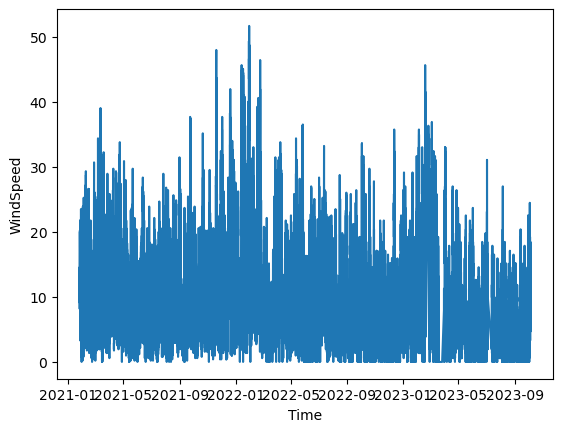

In [9]:
sns.lineplot(data=df, x='Time', y='WindSpeed')

In [10]:
df.to_csv('data.csv')

In [11]:
# Read the MySQL configuration from the JSON file
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

In [13]:
# Extract MySQL connection details
mysql_config = config.get('mysql', {})
username = mysql_config.get('username', 'default_username')
password = mysql_config.get('password', 'default_password')
host = mysql_config.get('host', 'localhost')
database_name = mysql_config.get('database_name', 'your_database')
table_name = 'measurments_rewa'

In [14]:
# Create the MySQL database connection string
db_url = f"mysql+mysqlconnector://{username}:{password}@{host}/{database_name}"

# Create an SQLAlchemy engine
engine = create_engine(db_url)

In [15]:
# Insert the Pandas DataFrame into the MySQL table
df.to_sql(table_name, engine, if_exists='replace', index=False)

128553